## Some assumptions made to keep things simple
>* Input data is set of pdf files download from  PURE Data set link : https://www.zenodo.eu/record/1414117.
>* It is unlabeled dataset.

## Load the dependencies

In [0]:
import os
import re
import pandas as pd
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate,PromptTemplate
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain
from langchain.chains import MapReduceDocumentsChain,ReduceDocumentsChain, StuffDocumentsChain
from langchain.chains.llm import LLMChain
import networkx as nx
import matplotlib.pyplot as plt

## LLM configuration and Data configuration

In [0]:
# Set up OpenAI API key using Databricks Secrets API
API_KEY = "********"
API_ENDPOINT = "https://YOUR_RESOURCE_NAME/"  # your endpoint should look like the following https://YOUR_RESOURCE_NAME/
API_VERSION = "2024-02-01"
LLM_DEPLOYMENT_NAME = "********"



### Task 1 Data collection and Prepration

Data Descrption : 
>* Data downloade from PURE link()
>* Data contains 5 srs documents in pdf format

Preprocessing Steps:
>* Loading the pdf files using pypdf package as pages
>* Apply the following preprocessing techniques over the pds file are normalization , Removing special characters , removing header , footers and urls from the documents.
>* splitting the document using the follwoing configuration
>* storing the result in text formate for each pdf

### Load Data Component

In [0]:
def load_pdf(file_name):
  loader = PyPDFLoader(file_name)
  pages = loader.load()
  return pages

In [0]:
def preprocess_document(pages):
    """
    Preprocess a list of raw text.
    Args:
        raw_text
    Returns:
        clean text
    """
    for index in range(len(pages)) : 
      # Basic cleanup: remove extra whitespace and line breaks
      cleaned_text = re.sub(r'\s+', ' ', pages[index].page_content).strip()
      # # Further preprocessing can be added here (e.g., removing special characters, lowercasing, etc.)
      # cleaned_text = re.sub(r'[^A-Za-z0-9\s]', '', cleaned_text)
      # removing hyper links
      cleaned_text = re.sub(r'http[s]?://\S+', '', cleaned_text)
      # nomalizing the text
      cleaned_text = cleaned_text.lower()
      # To Do some generalize technique can be applied to remove header and footer from the text
      pages[index].page_content = cleaned_text
    
    return pages

In [0]:
## Split Data Component
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=550, chunk_overlap=75)


### Storing the processed data into text files 

In [0]:
# runner code
# import glob
# files = glob.glob("<yourpath>/*.pdf")
# file_path = "/2007___puget_sound.pdf"
file_path = "/2001___ctc_network.pdf"
raw_pages = load_pdf(file_path)
cleaned_pages = preprocess_document(raw_pages)
splits=text_splitter.split_documents(cleaned_pages)

In [0]:
len(splits) , len(cleaned_pages)

(32, 32)

In [0]:
splits[10]

Document(page_content='software requirements specification 7table 4. lane closure interface requirements requirement numberrequirement description rationale or comments c2c-if-is06the center shall support the following information about each lane closure: 1. network identifier 2. lane closure id 3. closure description 4. starting roadway 5. starting cross street 6. latitude/longitude of starting location 7. ending roadway 8. ending cross street 9. latitude/longitude of ending location 10. direction of roadway 11. link identifier 12. current status 13. update type 14. affected lanes 15. lane closure source 16. contact 17. days closed 18. start time of day 19. end time of day 20. start date of series 21. end date of series 2.1.5 dynamic message sign interface requirements table 5 lists the interface requirements for supporting the dynamic message sign (dms) data transmission.', metadata={'source': '/dbfs/FileStore/Open_ai_usecases_data/2001___ctc_network.pdf', 'page': 10})

## Task 2 Workflow Suggestion using LLMs
>* Define the Map reduice custom chain which includes map and reduce prompt templates
>* grouping the semantice requirments into groups using LLMs
>* parsing this output into funcitonal requirments and non funcitonal dictionaries
>* Generating the graph

### LLM  Component

In [0]:
# Initialize the Azure OpenAI client
llmClient = AzureChatOpenAI(
        azure_endpoint =  API_ENDPOINT, 
        api_key = API_KEY,  
        api_version = API_VERSION,
        deployment_name = LLM_DEPLOYMENT_NAME,
        )
llmClient

In [0]:
# Map
map_template = """As a software designer, your task is to analyze a subset of SRS documents for various products and extract both functional and non-functional requirements. some details around what is functional and non functional requirements.Functional Requirements means Look for statements that describe what the software should do. These often involve actions, behaviors, or interactions (e.g., “The system shall allow users to log in”).
Non-Functional Requirements means  Identify constraints, quality attributes, and performance expectations (e.g., “Response time should be less than 2 seconds”).
SRS document page portion : 
{docs}
Based on this list of docs, please identify all functional and non functional requirements at high level.
Note : You have to Skip Irrelevant Sections like Disregard pages or sections containing content, results, stakeholder involvement, assumptions details, and appendices.

Helpful Answer:"""


In [0]:
map_prompt = PromptTemplate.from_template(map_template)
map_chain = LLMChain(llm=llmClient, prompt=map_prompt)

In [0]:
# Reduce Prompt 1
reduce_template= """Extracting Functional and Non-Functional Requirements and maintian the oreder while considering data and task dependency.Given the provided collection of functional and non-functional requirements for the product, analyze the following documents:

{docs}

Task: Identify all functional and non-functional requirements, merging similar ones, and present them in an order of execution and data depencies.  A helpful response would offer a clear and well-explained overview while covering all aspects."""



In [0]:
# Run chain
reduce_prompt = PromptTemplate.from_template(reduce_template)
reduce_chain = LLMChain(llm=llmClient, prompt=reduce_prompt)

In [0]:
# Takes a list of documents, combines them into a single string, and passes this to an LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)

# Combines and iteratively reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=7000,
)

In [0]:
# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="docs",
    # Return the results of the map steps in the output
    return_intermediate_steps=False,
)



In [0]:
splits[0].page_content

'software requirements specification (srs) for the dallas / ft. worth regional center-to-center communications network version 3.0 december 5, 2001 prepared for: software task force north central texas council of governments 616 six flags drive p.o. box 5888 arlington, tx 76005-5888 prepared by: southwest research institute post office drawer 28510, 6220 culebra road san antonio, texas 78228-0510'

In [0]:

result = map_reduce_chain.invoke(splits)
result

{'input_documents': [Document(page_content='software requirements specification (srs) for the dallas / ft. worth regional center-to-center communications network version 3.0 december 5, 2001 prepared for: software task force north central texas council of governments 616 six flags drive p.o. box 5888 arlington, tx 76005-5888 prepared by: southwest research institute post office drawer 28510, 6220 culebra road san antonio, texas 78228-0510', metadata={'source': '/dbfs/FileStore/Open_ai_usecases_data/2001___ctc_network.pdf', 'page': 0}),
  Document(page_content='software requirements specification iitable of contents page 1.0 scope ................................ ................................ ................................ ............................... 1 1.1 identificat ion................................ ................................ ................................ ....................... 1 1.2 system overview ................................ ................................

In [0]:
print(result['output_text'])

After analyzing the provided collection of functional and non-functional requirements for the product, we have identified a list of requirements and have merged similar ones. The following is a presentation of the requirements in an order of execution and data dependencies.

Functional Requirements:
1. The system shall allow users to log in.
2. The system shall interconnect several dissimilar traffic management systems.
3. The system shall provide a common repository for traffic information for the DFW metroplex.
4. The system shall allow data collection from various interfaces.
5. The system shall provide network device status information.
6. The system shall support traffic conditions data transmission for each link defined within the center.
7. The system shall support incident data transmission.
8. The system shall support lane closure data transmission.
9. The system shall support dynamic message sign (DMS) data transmission.
10. The system shall support lane control signal (LCS) 

### Group the related requirements and map non functional requirements.

In [0]:
input_template = """
As a software designer, your tasks are as follows:
1. Analyze and group related functional and non-functional requirements into high-level requirements.
2. Align each functional requirement with non-functional requirement tags (e.g., availability, performance).

Below is the list of functional and non-functional requirements you need to consider for this task:
{output_text}

Instructions:
- Group functional and non-functional requirements together.
- Provide the results as a list.
"""

In [0]:
prompt_template = PromptTemplate(template = input_template,
                                     input_variables =["output_text" ],
                                     )

chain = prompt_template | llmClient

final_result = chain.invoke(result['output_text'])

In [0]:
print(final_result.content)

Grouped Functional Requirements:
1. User Authentication
    - The system shall allow users to log in.
2. System Interconnectivity
    - The system shall interconnect several dissimilar traffic management systems.
3. Data Collection and Repository
    - The system shall provide a common repository for traffic information for the DFW metroplex.
    - The system shall allow data collection from various interfaces.
4. Network Device Status Information
    - The system shall provide network device status information.
5. Traffic Conditions Data Transmission
    - The system shall support traffic conditions data transmission for each link defined within the center.
6. Incident Data Transmission
    - The system shall support incident data transmission.
7. Lane Closure Data Transmission
    - The system shall support lane closure data transmission.
8. Dynamic Message Sign (DMS) Data Transmission
    - The system shall support dynamic message sign (DMS) data transmission.
9. Lane Control Signal

### Post processing the LLM output
>* Extracting the Non functional and functional requirements
>* creating the dictionaries for both

In [0]:
# Function to parse the requirements text into dictionaries
def parse_requirements(text):
    # Splitting the text into two parts: Functional and Non-Functional requirements
    functional_part, non_functional_part = text.split("Grouped Non-Functional Requirements")

    # Helper function to parse a section into a dictionary
    def parse_section(section):
        lines = section.strip().split("\n")
        current_key = ""
        requirements_dict = {}
        for line in lines:
          line = line.strip()
          if line.startswith("- "):
              requirements_dict[current_key].append(line[2:].strip())
          else:
              current_key = line.strip()
              requirements_dict[current_key] = []
        return requirements_dict

    # Parsing both sections
    functional_requirements = parse_section(functional_part)
    non_functional_requirements = parse_section(non_functional_part)

    return functional_requirements, non_functional_requirements

# Get the dictionaries
functional_requirements, non_functional_requirements = parse_requirements(final_result.content)

# Print the dictionaries (for verification)
print("Functional Requirements:")
print(functional_requirements)
print("\nNon-Functional Requirements:")
print(non_functional_requirements)

Functional Requirements:
{'Grouped Functional Requirements:': [], '1. User Authentication': ['The system shall allow users to log in.'], '2. System Interconnectivity': ['The system shall interconnect several dissimilar traffic management systems.'], '3. Data Collection and Repository': ['The system shall provide a common repository for traffic information for the DFW metroplex.', 'The system shall allow data collection from various interfaces.'], '4. Network Device Status Information': ['The system shall provide network device status information.'], '5. Traffic Conditions Data Transmission': ['The system shall support traffic conditions data transmission for each link defined within the center.'], '6. Incident Data Transmission': ['The system shall support incident data transmission.'], '7. Lane Closure Data Transmission': ['The system shall support lane closure data transmission.'], '8. Dynamic Message Sign (DMS) Data Transmission': ['The system shall support dynamic message sign (DMS

### Graph Nodes and dependcies creation

In [0]:
# Convert the keys of the functional_requirements dictionary to a list
keys = list(functional_requirements.keys())

# Initialize an empty list to store high-level dependencies
dependencies = []

# Loop through the keys to create dependencies between consecutive high-level requirements
for index in range(len(keys) - 1):
    # Check if the current key has any values (sub-requirements)
    if len(functional_requirements[keys[index]]) > 0:
        # Add a tuple representing the dependency between consecutive high-level requirements
        dependencies.append((keys[index], keys[index + 1]))

# Initialize an empty list to store detailed task dependencies
task_dependencies = []

# Initialize an empty set to store all unique tasks
task = set()

# Loop through the functional_requirements dictionary
for key, value_list in functional_requirements.items():
    # Check if the current key has any values (sub-requirements)
    if len(value_list) > 0:
        # Add the high-level task (key) to the set of tasks
        task.add(key)
        # Loop through the sub-requirements (values) of the current key
        for value in value_list:
            # Add a tuple representing the dependency between the high-level task and its sub-requirements
            task_dependencies.append((key, value))
            # Add the sub-requirement (value) to the set of tasks
            task.add(value)

# Extend the dependencies list with the detailed task dependencies
dependencies.extend(task_dependencies)


In [0]:
dependencies

[('1. User Authentication', '2. System Interconnectivity'),
 ('2. System Interconnectivity', '3. Data Collection and Repository'),
 ('3. Data Collection and Repository', '4. Network Device Status Information'),
 ('4. Network Device Status Information',
  '5. Traffic Conditions Data Transmission'),
 ('5. Traffic Conditions Data Transmission', '6. Incident Data Transmission'),
 ('6. Incident Data Transmission', '7. Lane Closure Data Transmission'),
 ('7. Lane Closure Data Transmission',
  '8. Dynamic Message Sign (DMS) Data Transmission'),
 ('8. Dynamic Message Sign (DMS) Data Transmission',
  '9. Lane Control Signal (LCS) Data Transmission'),
 ('9. Lane Control Signal (LCS) Data Transmission',
  '10. Closed Circuit Television (CCTV) Data Transmission'),
 ('10. Closed Circuit Television (CCTV) Data Transmission',
  '11. Ramp Meter Data Transmission'),
 ('11. Ramp Meter Data Transmission',
  '12. Highway Advisory Radio (HAR) Data Transmission'),
 ('12. Highway Advisory Radio (HAR) Data Tr

### Display

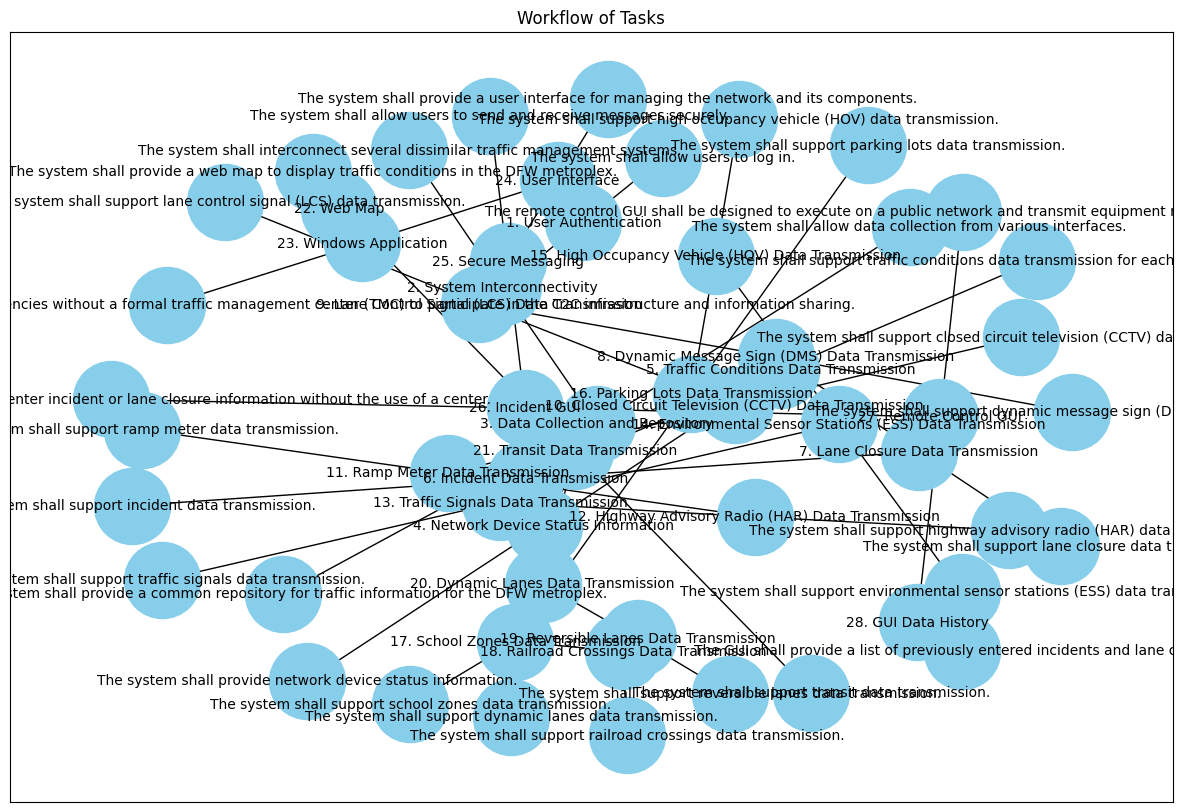

In [0]:
# Create a directed graph
workflow = nx.DiGraph()

workflow.add_nodes_from(task)

workflow.add_edges_from(dependencies)

# Draw the workflow
pos = nx.spring_layout(workflow)  # positions for all nodes
plt.figure(figsize=(15, 10))

# Draw the nodes and edges with labels
nx.draw_networkx_nodes(workflow, pos, node_size=3000, node_color='skyblue', node_shape='o')
nx.draw_networkx_edges(workflow, pos, edgelist=dependencies, edge_color='black', arrows=True)
nx.draw_networkx_labels(workflow, pos, font_size=10, font_family='sans-serif')

plt.title("Workflow of Tasks")
plt.show()



### Evaluation:
>* We can compare the functional requirements with ground truth using the Rouge method.